# Setup

In [1]:
# # Python >= 3.5 is require
# # try any version python 3 first 
# import sys
# assert sys.version_info >= (3,5)

# Scikit-Learn >= 0.2 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Saving figure some_digit_plot


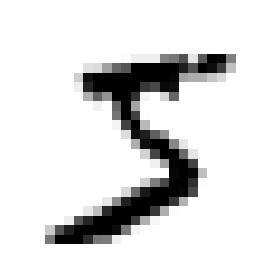

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
              interpolation="nearest")
    plt.axis("off")

In [9]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    image_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


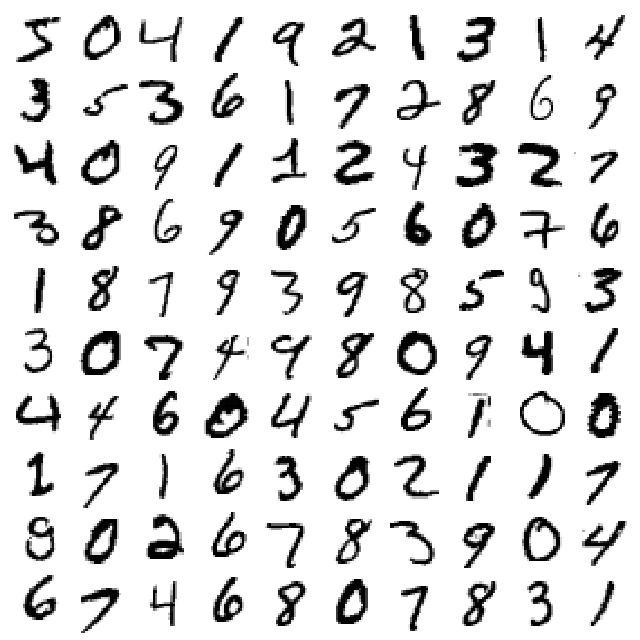

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [11]:
y[0]

5

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary classifier

In [13]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
# from sklearn own cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
# manual way of cross-validation
# (use when you need more control)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\JEFFf\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


Note: it may seem that the classifier is performing very well. Is it reall?

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Note: accuracy is generaly not prefered because some datasets will be skewed (i.e. when some classes are much more frequenct than others)

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
3530 / (3530 + 687)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [25]:
3530 / (3530 + 1891)

0.6511713705958311

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
3530 / (3530 + (687 + 1891) / 2)

0.7325171197343847

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [30]:
y_some_digit_pred

array([ True])

In [31]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


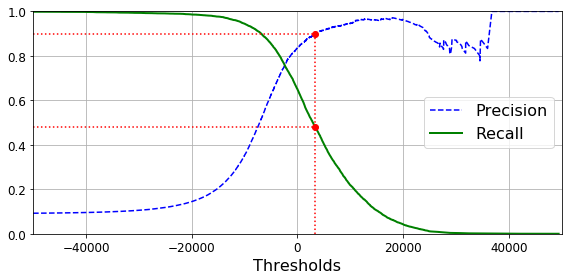

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Thresholds", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")

plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")

plt.plot([-50000, threshold_90_precision],
         [recall_90_precision, recall_90_precision],
         "r:")

plt.plot([threshold_90_precision], [0.9], "ro")

plt.plot([threshold_90_precision], [recall_90_precision], "ro")

save_fig("precision_recall_vs_threshold_plot")

plt.show()

In [35]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


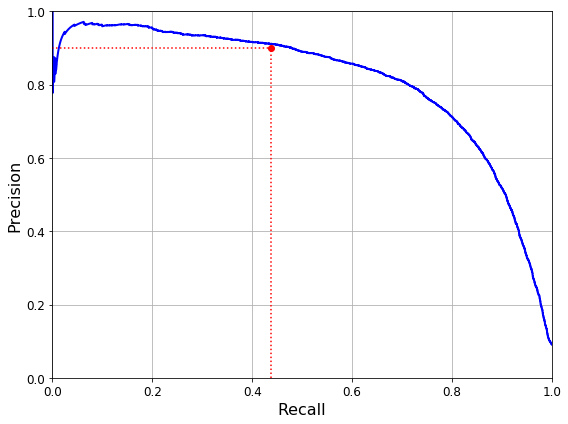

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [37]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [38]:
threshold_90_precision

3370.0194991439557

In [39]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [40]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


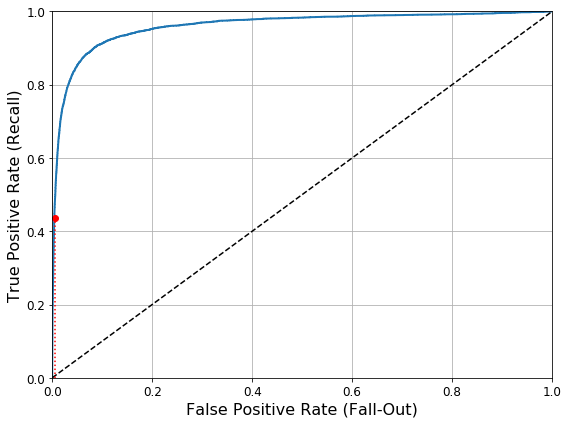

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
save_fig("roc_curve_plot")
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [45]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [46]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, threshols_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


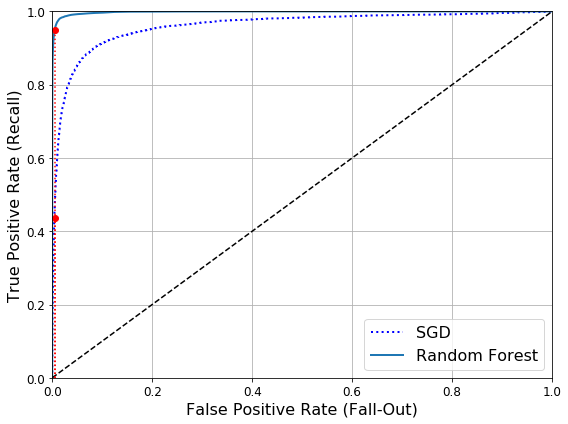

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [49]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# Multiclass classification

In [51]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
some_digit_scores =svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [53]:
np.argmax(some_digit_scores)

5

In [54]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
svm_clf.classes_[5]

5

In [56]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
len(ovr_clf.estimators_)

10

In [58]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [59]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [62]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

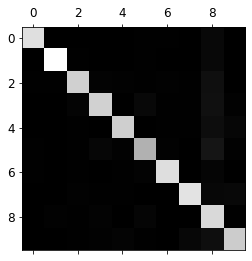

In [63]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [64]:
row_sums =conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

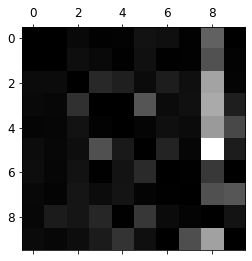

In [65]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Saving figure error_analysis_digits_plot


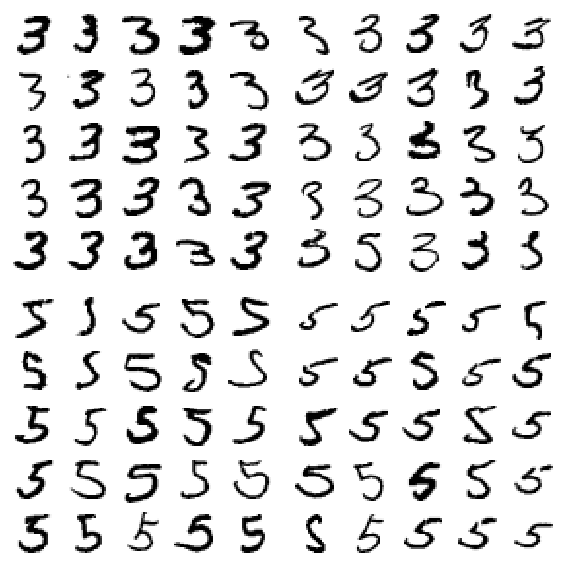

In [66]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel classification

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [68]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput classification

In [70]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


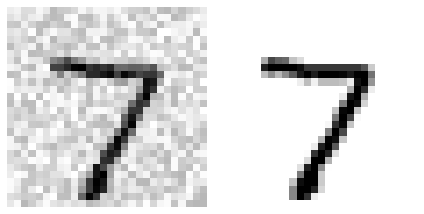

In [71]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


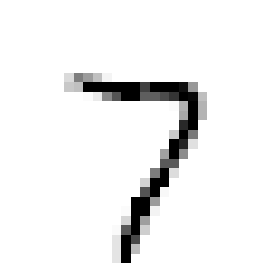

In [72]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

## Extra material

### Dummy (i.e. random) classifier

In [73]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy= cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

C:\Users\JEFFf\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


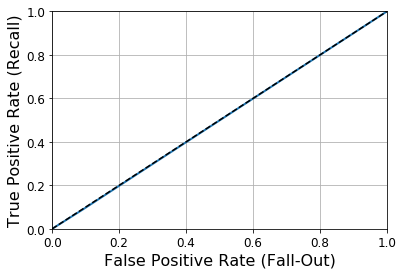

In [74]:
fprr, tprr, thresholder = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

### KNN classifier

In [75]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights="distance", n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [76]:
y_knn_pred = knn_clf.predict(X_test)

In [77]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

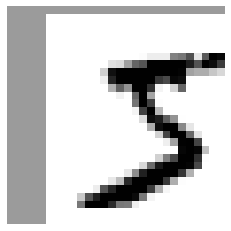

In [78]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [79]:
X_train_expanded = [X_train]
y_train_expanded= [y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)
    
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [80]:
X = X_train_expanded
y = y_train_expanded

knn_clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [82]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [84]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [85]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

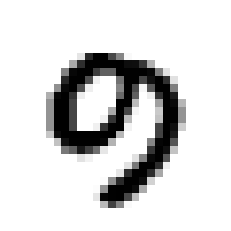

In [87]:
plot_digit(ambiguous_digit)

# Excercises

### 1. MNIST classifier above 97% accuracy

In [90]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'weights':['uniform', 'distance'],
    'n_neighbors':[2,3,4]
}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)

X = X_train
y = y_train
grid_search.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=2, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=2, weights=uniform, score=0.964, total=11.7min
[CV] n_neighbors=2, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.7min remaining:    0.0s


[CV] ...... n_neighbors=2, weights=uniform, score=0.963, total=13.7min
[CV] n_neighbors=2, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 25.4min remaining:    0.0s


[CV] ...... n_neighbors=2, weights=uniform, score=0.962, total=12.1min
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ...... n_neighbors=2, weights=uniform, score=0.963, total=11.4min
[CV] n_neighbors=2, weights=uniform ..................................
[CV] ...... n_neighbors=2, weights=uniform, score=0.964, total=11.2min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.970, total=11.2min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.971, total=11.2min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.969, total=11.2min
[CV] n_neighbors=2, weights=distance .................................
[CV] ..... n_neighbors=2, weights=distance, score=0.969, total=11.2min
[CV] n_neighbors=2, weights=distance .................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 365.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [2, 3, 4],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [91]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [92]:
grid_search.best_score_

0.9716166666666666

In [93]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

In [94]:
from sklearn.metrics import classification_report
classification_report(y_test, y_knn_pred)

'              precision    recall  f1-score   support\n\n           0       0.97      0.99      0.98       980\n           1       0.97      1.00      0.98      1135\n           2       0.98      0.96      0.97      1032\n           3       0.97      0.96      0.97      1010\n           4       0.98      0.97      0.97       982\n           5       0.96      0.97      0.96       892\n           6       0.98      0.99      0.98       958\n           7       0.96      0.97      0.96      1028\n           8       0.99      0.94      0.97       974\n           9       0.96      0.96      0.96      1009\n\n    accuracy                           0.97     10000\n   macro avg       0.97      0.97      0.97     10000\nweighted avg       0.97      0.97      0.97     10000\n'

### 2. Data augmentation

In [97]:
from scipy.ndimage.interpolation import shift
def shift_digit(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy,dx])
    
    return shifted_image.reshape([-1])

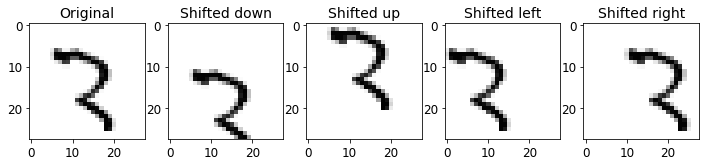

In [102]:
image = X_train[500]
shifted_image_down = shift_digit(image, 0, 5)
shifted_image_up = shift_digit(image, 0, -5)
shifted_image_left = shift_digit(image, -5, 0)
shifted_image_right = shift_digit(image, 5, 0)

plt.figure(figsize=(12,3))
plt.subplot(1,5,1)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28,28), interpolation='nearest', cmap='Greys')
plt.subplot(1,5,2)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28,28), interpolation='nearest', cmap='Greys')
plt.subplot(1,5,3)
plt.title("Shifted up", fontsize=14)
plt.imshow(shifted_image_up.reshape(28,28), interpolation='nearest', cmap='Greys')
plt.subplot(1,5,4)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28,28), interpolation='nearest', cmap='Greys')
plt.subplot(1,5,5)
plt.title("Shifted right", fontsize=14)
plt.imshow(shifted_image_right.reshape(28,28), interpolation='nearest', cmap='Greys')
plt.show()